# Copa America 2019 Prediction
The purpose of this is to try and predict the top 3 teams for Copa America 2019 using classification models coupled with poisson distribution to predict the exact results of the semi-finals, third place playoff and final.

## Final Predictions
__Winner:__ Brazil <br>
__Runners-up:__ Argentina <br>
__Third Place:__ Uruguay <br>
__Fourth Place:__ Colombia <br>
__Final Score:__ Brazil 2:1 Argentina <br>
__Third Place Playoff Score:__ Uruguay 1:0 Colombia <br>

### Contents:
1. Importing Necessary Packages/Datasets
2. Data Cleaning
3. Classification Models for Predicting Results __(Win/Draw/Lose)__
     - Variables Used:
          - Which Stadium the match is played in __(0-Neutral, 1-Otherwise)__.
          - __Importance__ of match (0-Friendly, 1-Others).
          - How much the Home Team's __Points__ have changed.
          - How much the Away Team's __Points__ have changed.
          - Difference in team's __Ranking__.
          - Difference in __Mean Weighted Points__ over the past 3 years.
4. Classification Models to Predict exact __Home/Away Goals__.
     - Variables used are same as in 3.
5. Visualizing __Current Ability__ and __Potential__ of players of participating nations
6. Variables to build a __Poisson__ Model
     - Variables used:
          - Soccer Power Index
          - Average Age
          - Average Height
          - Past Participation
          - Average goals scored per game
          - Average goals conceded per game
          - Potential
          - Current Ability
7. Predicting Copa America 2019

## 1. Importing Necessary Packages/Datasets

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import poisson
import random
import warnings
warnings.filterwarnings('ignore')

###### Classifiers Libraries

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
result=pd.read_csv(r"E:\ML\Project\results.csv")
ranking=pd.read_csv(r"E:\ML\Project\ranking.csv",encoding='latin-1')
squads = pd.read_csv(r'E:\ML\Project\squads_upd.csv')
fifa19 = pd.read_csv(r'E:\ML\Project\fifa19_cleaned.csv')
df=pd.read_csv(r"E:\ML\Project\spi.csv")
history=pd.read_csv(r'E:\ML\Project\history team.csv',delimiter='\t')
fixtures=pd.read_csv(r'E:\ML\Project\copa_fixtures.csv')

## 2. Data Cleaning

Function to calculate __Mean Weighted Points__ over the past 3 years.

In [4]:
def meanWeighted(l,year,country):
    if l>2:
        currentYear = int(ranking.ix[(ranking['country_full']==country) & (ranking['year']==[year])]['mean_pts'].head(1))
        previousYear = int(ranking.ix[(ranking['country_full']==country) & (ranking['year']==[year-1])]['mean_pts'].head(1))
        previous2Year = int(ranking.ix[(ranking['country_full']==country) & (ranking['year']==[year-2])]['mean_pts'].head(1))
        weighted = (0.5*currentYear)+(0.3*previousYear)+(0.2*previous2Year)
    elif l==2 and year>=2012:
        currentYear = int(ranking.ix[(ranking['country_full']==country) & (ranking['year']==[year])]['mean_pts'].head(1))
        previousYear = int(ranking.ix[(ranking['country_full']==country) & (ranking['year']==[year-1])]['mean_pts'].head(1))
        weighted = (0.6*currentYear)+(0.4*previousYear)
    else:
        weighted = int(ranking[(ranking['year']==year)]['mean_pts'].head(1))
    return weighted

In [5]:
countries = ranking.country_full.unique().tolist()
countries.sort()

result = result[result.home_team.isin(countries)]
result = result[result.away_team.isin(countries)]

In [6]:
ranking['pts_diff'] = round(ranking['total_points'] - ranking['previous_points'])
ranking['rank_date'] = pd.to_datetime(ranking['rank_date'], format='%d-%m-%Y')
ranking.rename(columns={'rank_date':'date'},inplace=True)
ranking['day'] = ranking['date'].dt.day
ranking['month'] = ranking['date'].dt.month
ranking['year'] = ranking['date'].dt.year
ranking['mean_pts'] = ranking.groupby(['country_full','year']).transform(lambda x: x.mean())['total_points']
ranking['mean_weighted'] = 0
for country in countries:
    years = ranking.ix[ranking['country_full']==country]['year'].unique().tolist()
    years.sort(reverse=True)
    l = len(years)
    for year in years:
        ranking['mean_weighted'] = np.where((ranking['year']==year) & (ranking['country_full']==country),meanWeighted(l,year,country),ranking['mean_weighted'])
        l -= 1

In [7]:
current_ranking = ranking[ranking['date']=='2019-06-14']
ranking.drop(['date','previous_points'],axis=1,inplace=True)
ranking.head(3)

,rank,country_full,total_points,confederation,pts_diff,day,month,year,mean_pts,mean_weighted
0,1,Netherlands,1596.13,UEFA,54.0,24,8,2011,1464.624,1464.0
1,2,Spain,1563.45,UEFA,-25.0,24,8,2011,1584.144,1464.0
2,3,Germany,1329.86,UEFA,25.0,24,8,2011,1332.530,1464.0


In [8]:
current_ranking.head(3)

,date,rank,country_full,total_points,previous_points,confederation,pts_diff,day,month,year,mean_pts,mean_weighted
19524,2019-06-14,1,Belgium,1746.0,1737,UEFA,9.0,14,6,2019,1733.500000,1579.5
19525,2019-06-14,2,France,1718.0,1734,UEFA,-16.0,14,6,2019,1727.333333,1542.4
19526,2019-06-14,3,Brazil,1681.0,1676,CONMEBOL,5.0,14,6,2019,1676.833333,1618.7


In [9]:
result['date'] = pd.to_datetime(result['date'], format='%d-%m-%Y')
result['day'] = result['date'].dt.day
result['month'] = result['date'].dt.month
result['year'] = result['date'].dt.year

result['results'] = np.where(result['home_score']>result['away_score'],2,np.where(result['home_score']==result['away_score'],1,0))
result['impt'] = np.where(result['tournament']=='Friendly',0,1)
result['host'] = np.where((result['country']==result['home_team']) | (result['country']==result['away_team']),1,0)
result.drop(['date','city','tournament','country'],axis=1,inplace=True)

In [10]:
result = pd.merge(left=result, right=ranking, how='left', left_on=['home_team','year','month'], right_on=['country_full','year','month'], suffixes=('_x','_y')).drop(['country_full','day_y','total_points','confederation'],axis=1)
result = pd.merge(left=result, right=ranking, how='left', left_on=['away_team','year','month'], right_on=['country_full','year','month'], suffixes=('_x','_y')).drop(['country_full','day','total_points','confederation'],axis=1)
result.rename(columns={'day_x':'day','rank_x':'home_rank','rank_y':'away_rank','pts_diff_x':'home_pts_diff','pts_diff_y':'away_pts_diff','mean_pts_x':'home_mean','mean_pts_y':'away_mean','mean_weighted_x':'home_weighted','mean_weighted_y':'away_weighted'},inplace=True)
result.update(result[['home_rank','away_rank','home_pts_diff','away_pts_diff','home_mean','away_mean','home_weighted','away_weighted']].fillna(0))
result['rank_diff'] = result['home_rank'] - result['away_rank']
result['mean_diff'] = result['home_mean'] - result['away_mean']
result['weighted_diff'] = result['home_weighted'] - result['away_weighted']
result.drop(['home_rank','away_rank','home_mean','away_mean','home_weighted','away_weighted'],axis=1,inplace=True)
result.tail()

,home_team,away_team,home_score,away_score,neutral,day,month,year,results,impt,host,home_pts_diff,away_pts_diff,rank_diff,mean_diff,weighted_diff
6658,Norway,Sweden,3,3,False,26,3,2019,1,1,1,0.0,0.0,34.0,-138.000000,-221.8
6659,Romania,Faroe Islands,4,1,False,26,3,2019,2,1,1,0.0,0.0,-72.0,275.333333,293.9
6660,Bosnia and Herzegovina,Greece,2,2,False,26,3,2019,1,1,1,0.0,0.0,-10.0,45.333333,53.7
6661,Italy,Liechtenstein,6,0,False,26,3,2019,2,1,1,0.0,0.0,-163.0,614.833333,744.0
6662,Armenia,Finland,0,2,False,26,3,2019,0,1,1,0.0,-3.0,42.0,-160.666667,-110.8


## 3. Predicting Match Results (Win/Draw/Lose)

 - Variables Used:
     - Which Stadium the match is played in __(0-Neutral, 1-Otherwise)__.
     - __Importance__ of match (0-Friendly, 1-Others).
     - How much the Home Team's __Points__ have changed.
     - How much the Away Team's __Points__ have changed.
     - Difference in team's __Ranking__.
     - Difference in __Mean Weighted Points__ over the past 3 years.
 
 - We shall scale the features to speed up the process for __Distance__ based classifiers and also use 5-fold Cross Validation for Accuracy.

### 3.1 Splitting into Training and Test Sets

In [11]:
features = result.loc[0:,['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff']]
labels = result.loc[:,['results']]

sc = StandardScaler()
features = sc.fit_transform(features)
x_train,x_test,y_train,y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
x_train = pd.DataFrame(x_train,columns=['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff'])
x_test = pd.DataFrame(x_test,columns=['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff'])

k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

### 3.2 Building Classification Models

The models will be optimised using GridSearchCV based on F1 score. F1 score gives a weighted average between precision and accuracy/recall. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).

I have typed in some of the optimised parameters based on the GridSearchCV code output.

Confusion matrix table and details will only be shown for the final selected models in order to save space.

There would be a summary of each models in the evaluation section below.

#### Logistic Regression

In [12]:
Logistic_Reg = dict()
lr_class = LogisticRegression(C=0.001,n_jobs=-1)
lr_class.fit(x_train,y_train)
res_predict = lr_class.predict(x_test)
train_predict = lr_class.predict(x_train)
Logistic_Reg['Train Accuracy'] = round(np.mean(cross_val_score(lr_class,x_train,y_train,cv=k_fold,scoring="accuracy")),2)
Logistic_Reg['Test Accuracy'] = round(accuracy_score(y_test,res_predict),2)
Logistic_Reg['Train Precision'] = round(precision_score(y_train,train_predict,average='macro'),2)
Logistic_Reg['Test Precision'] = round(precision_score(y_test,res_predict,average='macro'),2)
Logistic_Reg['Train F1-Score'] = round(f1_score(y_train,train_predict,average='macro'),2)
Logistic_Reg['Test F1-Score'] = round(f1_score(y_test,res_predict,average='macro'),2)

#### Support Vector Machine (RBF Kernel)

In [13]:
SVM = dict()
svm_class = SVC(kernel='rbf',gamma=0.001,C=2,probability=True)
svm_class.fit(x_train,y_train)
res_predict = svm_class.predict(x_test)
train_predict = svm_class.predict(x_train)
SVM['Train Accuracy'] = round(np.mean(cross_val_score(svm_class,x_train,y_train,cv=k_fold,scoring="accuracy")),2)
SVM['Test Accuracy'] = round(accuracy_score(y_test,res_predict),2)
SVM['Train Precision'] = round(precision_score(y_train,train_predict,average='macro'),2)
SVM['Test Precision'] = round(precision_score(y_test,res_predict,average='macro'),2)
SVM['Train F1-Score'] = round(f1_score(y_train,train_predict,average='macro'),2)
SVM['Test F1-Score'] = round(f1_score(y_test,res_predict,average='macro'),2)

#### Support Vector Machine (Linear Kernel)

In [14]:
SVML = dict()
svml_class = SVC(kernel='linear', gamma=0.001, C=0.5, probability=True)
svml_class.fit(x_train,y_train)
res_predict = svml_class.predict(x_test)
train_predict = svml_class.predict(x_train)
SVML['Train Accuracy'] = round(np.mean(cross_val_score(svml_class,x_train,y_train,cv=k_fold,scoring="accuracy")),2)
SVML['Test Accuracy'] = round(accuracy_score(y_test,res_predict),2)
SVML['Train Precision'] = round(precision_score(y_train,train_predict,average='macro'),2)
SVML['Test Precision'] = round(precision_score(y_test,res_predict,average='macro'),2)
SVML['Train F1-Score'] = round(f1_score(y_train,train_predict,average='macro'),2)
SVML['Test F1-Score'] = round(f1_score(y_test,res_predict,average='macro'),2)

#### K-Nearest Neighbors

In [15]:
KNN = dict()
knn_class = KNeighborsClassifier(n_neighbors=11,p=2,weights='distance',n_jobs=-1)
knn_class.fit(x_train,y_train)
res_predict = knn_class.predict(x_test)
train_predict = knn_class.predict(x_train)
KNN['Train Accuracy'] = round(np.mean(cross_val_score(knn_class,x_train,y_train,cv=k_fold,scoring="accuracy")),2)
KNN['Test Accuracy'] = round(accuracy_score(y_test,res_predict),2)
KNN['Train Precision'] = round(precision_score(y_train,train_predict,average='macro'),2)
KNN['Test Precision'] = round(precision_score(y_test,res_predict,average='macro'),2)
KNN['Train F1-Score'] = round(f1_score(y_train,train_predict,average='macro'),2)
KNN['Test F1-Score'] = round(f1_score(y_test,res_predict,average='macro'),2)

#### Decision Tree

In [16]:
DT = dict()
dt_class = DecisionTreeClassifier(max_depth= 9, max_leaf_nodes= 80, min_samples_leaf= 6, min_samples_split= 2)
dt_class.fit(x_train,y_train)
res_predict = dt_class.predict(x_test)
train_predict = dt_class.predict(x_train)
DT['Train Accuracy'] = round(np.mean(cross_val_score(dt_class,x_train,y_train,cv=k_fold,scoring="accuracy")),2)
DT['Test Accuracy'] = round(accuracy_score(y_test,res_predict),2)
DT['Train Precision'] = round(precision_score(y_train,train_predict,average='macro'),2)
DT['Test Precision'] = round(precision_score(y_test,res_predict,average='macro'),2)
DT['Train F1-Score'] = round(f1_score(y_train,train_predict,average='macro'),2)
DT['Test F1-Score'] = round(f1_score(y_test,res_predict,average='macro'),2)

#### Random Forest

In [17]:
RF = dict()
rf_class = RandomForestClassifier(n_estimators=250,max_depth= 8, max_leaf_nodes=100, min_samples_leaf= 5, min_samples_split= 5, n_jobs=-1)
rf_class.fit(x_train,y_train)
res_predict = rf_class.predict(x_test)
train_predict = rf_class.predict(x_train)
RF['Train Accuracy'] = round(np.mean(cross_val_score(rf_class,x_train,y_train,cv=k_fold,scoring="accuracy")),2)
RF['Test Accuracy'] = round(accuracy_score(y_test,res_predict),2)
RF['Train Precision'] = round(precision_score(y_train,train_predict,average='macro'),2)
RF['Test Precision'] = round(precision_score(y_test,res_predict,average='macro'),2)
RF['Train F1-Score'] = round(f1_score(y_train,train_predict,average='macro'),2)
RF['Test F1-Score'] = round(f1_score(y_test,res_predict,average='macro'),2)

#### XGBoost

In [18]:
XGB = dict()
xgb_class = xgb.XGBClassifier(max_depth=10, n_estimators=50, learning_rate=0.1, n_jobs=-1)
xgb_class.fit(x_train,y_train)
res_predict = xgb_class.predict(x_test)
train_predict = xgb_class.predict(x_train)
XGB['Train Accuracy'] = round(np.mean(cross_val_score(xgb_class,x_train,y_train,cv=k_fold,scoring="accuracy")),2)
XGB['Test Accuracy'] = round(accuracy_score(y_test,res_predict),2)
XGB['Train Precision'] = round(precision_score(y_train,train_predict,average='macro'),2)
XGB['Test Precision'] = round(precision_score(y_test,res_predict,average='macro'),2)
XGB['Train F1-Score'] = round(f1_score(y_train,train_predict,average='macro'),2)
XGB['Test F1-Score'] = round(f1_score(y_test,res_predict,average='macro'),2)

### 3.3 Model Evaluation

In [19]:
clfResults = pd.DataFrame.from_records([Logistic_Reg,SVM,SVML,KNN,DT,RF,XGB],index=['Logistic Regession','Support Vector Machine (RBF)','Support Vector Machine (Linear)','K-Nearest Neighbors','Decision Tree','Random Forest','XGBoost'])
col = clfResults.columns.tolist()
col = [col[i] for i in [3,0,5,2,4,1]]
clfResults = clfResults[col]
clfResults

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train F1-Score,Test F1-Score
Logistic Regession,0.59,0.59,0.39,0.38,0.44,0.44
Support Vector Machine (RBF),0.59,0.60,0.39,0.39,0.43,0.44
Support Vector Machine (Linear),0.59,0.60,0.39,0.39,0.44,0.44
K-Nearest Neighbors,0.56,0.57,0.99,0.51,0.99,0.50
Decision Tree,0.57,0.58,0.62,0.49,0.55,0.47
Random Forest,0.60,0.61,0.69,0.52,0.57,0.48
XGBoost,0.58,0.59,0.92,0.53,0.89,0.52


Although __XGBoost__ has the highest __F1-Score__, we will use __Random Forest Classifier__ as it has higher __Test Accuracy__ and __Test Precision__ values with __F1-Score__ almost being the same as XGBoost. In XGboost, the difference between Training and Test Precision, and Train and Test F1-Score is higher, which makes it overfitted.

#### Confusion Matrix for the Selected Model

In [20]:
cm=confusion_matrix(y_train,rf_class.predict(x_train))
col=["Predicted Away Win","Predicted Draw","Predicted Home Win"]
cm=pd.DataFrame(cm)
cm.columns=["Predicted Away Win","Predicted Draw","Predicted Home Win"]
cm.index=["Actual Away Win","Actual Draw","Actual Home Win"]
cm.T

,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,1063,329,212
Predicted Draw,32,205,31
Predicted Home Win,437,758,2263


##### Important Features for the Selected Model

(0, 0.4)

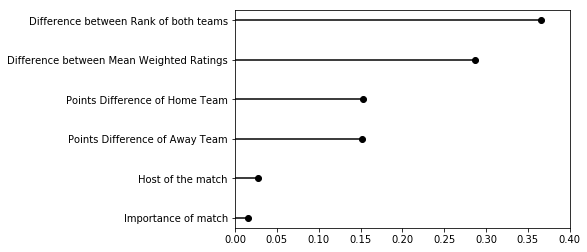

In [21]:
impFeatures = pd.DataFrame()
impFeatures['Feature'] = ['Host of the match', 'Importance of match', 'Points Difference of Home Team', 'Points Difference of Away Team', 'Difference between Rank of both teams', 'Difference between Mean Weighted Ratings']
impFeatures['Feature Importance'] = rf_class.feature_importances_
impFeatures.sort_values(by=['Feature Importance'], ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(6,4))
ax.hlines(impFeatures['Feature'], xmin=0, xmax=impFeatures['Feature Importance'])
ax.plot(impFeatures['Feature Importance'],impFeatures['Feature'],"o",color='black')
ax.set_xlim(0,0.4)

## 4. Predicting Goals Scored by Home and Away Teams

Variables used are same as in __3__.

### 4.1 Splitting into Training and Test Sets

In [22]:
features = result.loc[0:,['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff']]
labels_home = result.loc[:,['home_score']]
labels_away = result.loc[:,['away_score']]

sc = StandardScaler()
features = sc.fit_transform(features)
x_home_train,x_home_test,y_home_train,y_home_test = train_test_split(features, labels_home, test_size=0.2, random_state=0)
x_away_train,x_away_test,y_away_train,y_away_test = train_test_split(features, labels_away, test_size=0.2, random_state=0)

x_home_train = pd.DataFrame(x_train,columns=['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff'])
x_home_test = pd.DataFrame(x_test,columns=['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff'])
x_away_train = pd.DataFrame(x_train,columns=['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff'])
x_away_test = pd.DataFrame(x_test,columns=['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff'])

k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

### 4.2 Predicting goals scored by Home team

As done in previous section, models will be optimised using GridSearchCV based on F1-Score.

I have typed in some of the optimised parameters based on the GridSearchCV code output.

There would be a summary of each models in the evaluation section below.

#### Logistic Regression

In [23]:
Logistic_Reg_Home = dict()
lr_home = LogisticRegression(C=0.0001, n_jobs=-1)
lr_home.fit(x_home_train,y_home_train)
res_predict = lr_home.predict(x_home_test)
train_predict = lr_home.predict(x_home_train)
Logistic_Reg_Home['Train Accuracy'] = round(np.mean(cross_val_score(lr_home,x_home_train,y_home_train,cv=k_fold,scoring="accuracy")),2)
Logistic_Reg_Home['Test Accuracy'] = round(accuracy_score(y_home_test,res_predict),2)
Logistic_Reg_Home['Train Precision'] = round(precision_score(y_home_train,train_predict,average='macro'),2)
Logistic_Reg_Home['Test Precision'] = round(precision_score(y_home_test,res_predict,average='macro'),2)
Logistic_Reg_Home['Train F1-Score'] = round(f1_score(y_home_train,train_predict,average='macro'),2)
Logistic_Reg_Home['Test F1-Score'] = round(f1_score(y_home_test,res_predict,average='macro'),2)

#### Support Vector Machine (RBF Kernel)

In [24]:
SVM_Home = dict()
svm_home = SVC(kernel='rbf', gamma=0.001, C=2, probability=True)
svm_home.fit(x_home_train,y_home_train)
res_predict = svm_home.predict(x_home_test)
train_predict = svm_home.predict(x_home_train)
SVM_Home['Train Accuracy'] = round(np.mean(cross_val_score(svm_home,x_home_train,y_home_train,cv=k_fold,scoring="accuracy")),2)
SVM_Home['Test Accuracy'] = round(accuracy_score(y_home_test,res_predict),2)
SVM_Home['Train Precision'] = round(precision_score(y_home_train,train_predict,average='macro'),2)
SVM_Home['Test Precision'] = round(precision_score(y_home_test,res_predict,average='macro'),2)
SVM_Home['Train F1-Score'] = round(f1_score(y_home_train,train_predict,average='macro'),2)
SVM_Home['Test F1-Score'] = round(f1_score(y_home_test,res_predict,average='macro'),2)

#### K-Nearest Neighbors

In [25]:
KNN_Home = dict()
knn_home = KNeighborsClassifier(n_neighbors=19, p=1, weights='distance', n_jobs=-1)
knn_home.fit(x_home_train,y_home_train)
res_predict = knn_home.predict(x_home_test)
train_predict = knn_home.predict(x_home_train)
KNN_Home['Train Accuracy'] = round(np.mean(cross_val_score(knn_home,x_home_train,y_home_train,cv=k_fold,scoring="accuracy")),2)
KNN_Home['Test Accuracy'] = round(accuracy_score(y_home_test,res_predict),2)
KNN_Home['Train Precision'] = round(precision_score(y_home_train,train_predict,average='macro'),2)
KNN_Home['Test Precision'] = round(precision_score(y_home_test,res_predict,average='macro'),2)
KNN_Home['Train F1-Score'] = round(f1_score(y_home_train,train_predict,average='macro'),2)
KNN_Home['Test F1-Score'] = round(f1_score(y_home_test,res_predict,average='macro'),2)

#### Decision Tree

In [26]:
DT_Home = dict()
dt_home = DecisionTreeClassifier(max_depth= 5, max_leaf_nodes= 50, min_samples_leaf= 5, min_samples_split= 2)
dt_home.fit(x_home_train,y_home_train)
res_predict = dt_home.predict(x_home_test)
train_predict = dt_home.predict(x_home_train)
DT_Home['Train Accuracy'] = round(np.mean(cross_val_score(dt_home,x_home_train,y_home_train,cv=k_fold,scoring="accuracy")),2)
DT_Home['Test Accuracy'] = round(accuracy_score(y_home_test,res_predict),2)
DT_Home['Train Precision'] = round(precision_score(y_home_train,train_predict,average='macro'),2)
DT_Home['Test Precision'] = round(precision_score(y_home_test,res_predict,average='macro'),2)
DT_Home['Train F1-Score'] = round(f1_score(y_home_train,train_predict,average='macro'),2)
DT_Home['Test F1-Score'] = round(f1_score(y_home_test,res_predict,average='macro'),2)

#### Random Forest

In [27]:
RF_Home = dict()
rf_home = RandomForestClassifier(n_estimators=100,max_depth= 7, max_leaf_nodes=110, min_samples_leaf= 3, min_samples_split= 2, n_jobs=-1)
rf_home.fit(x_home_train,y_home_train)
res_predict = rf_home.predict(x_home_test)
train_predict = rf_home.predict(x_home_train)
RF_Home['Train Accuracy'] = round(np.mean(cross_val_score(rf_home,x_home_train,y_home_train,cv=k_fold,scoring="accuracy")),2)
RF_Home['Test Accuracy'] = round(accuracy_score(y_home_test,res_predict),2)
RF_Home['Train Precision'] = round(precision_score(y_home_train,train_predict,average='macro'),2)
RF_Home['Test Precision'] = round(precision_score(y_home_test,res_predict,average='macro'),2)
RF_Home['Train F1-Score'] = round(f1_score(y_home_train,train_predict,average='macro'),2)
RF_Home['Test F1-Score'] = round(f1_score(y_home_test,res_predict,average='macro'),2)

#### XGBoost

In [28]:
XGB_Home = dict()
xgb_home = xgb.XGBClassifier(max_depth=6, n_estimators=150, learning_rate=0.01, n_jobs=-1)
xgb_home.fit(x_home_train,y_home_train)
res_predict = xgb_home.predict(x_home_test)
train_predict = xgb_home.predict(x_home_train)
XGB_Home['Train Accuracy'] = round(np.mean(cross_val_score(xgb_home,x_home_train,y_home_train,cv=k_fold,scoring="accuracy")),2)
XGB_Home['Test Accuracy'] = round(accuracy_score(y_home_test,res_predict),2)
XGB_Home['Train Precision'] = round(precision_score(y_home_train,train_predict,average='macro'),2)
XGB_Home['Test Precision'] = round(precision_score(y_home_test,res_predict,average='macro'),2)
XGB_Home['Train F1-Score'] = round(f1_score(y_home_train,train_predict,average='macro'),2)
XGB_Home['Test F1-Score'] = round(f1_score(y_home_test,res_predict,average='macro'),2)

### 4.3 Model evaluation for classifiers used to predict goals for Home team

In [29]:
clfResultsHome = pd.DataFrame.from_records([Logistic_Reg_Home,SVM_Home,KNN_Home,DT_Home,RF_Home,XGB_Home],index=['Logistic Regession','Support Vector Machine (RBF)','K-Nearest Neighbors','Decision Tree','Random Forest','XGBoost'])
col = clfResultsHome.columns.tolist()
col = [col[i] for i in [3,0,5,2,4,1]]
clfResultsHome = clfResultsHome[col]
clfResultsHome

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train F1-Score,Test F1-Score
Logistic Regession,0.35,0.33,0.08,0.08,0.09,0.09
Support Vector Machine (RBF),0.35,0.33,0.06,0.06,0.07,0.07
K-Nearest Neighbors,0.33,0.33,1.00,0.13,1.00,0.11
Decision Tree,0.35,0.34,0.15,0.11,0.11,0.10
Random Forest,0.37,0.34,0.22,0.10,0.14,0.09
XGBoost,0.35,0.35,0.40,0.12,0.23,0.11


__K-Nearest Neighbors__ has the highest F1-Score, but the difference between Training and Test F1-Score is very large, which makes it overfitted.

### 4.4 Predicting goals scored by Away team

#### Logistic Regression

In [30]:
Logistic_Reg_Away = dict()
lr_away = LogisticRegression(C=0.001, n_jobs=-1)
lr_away.fit(x_away_train,y_away_train)
res_predict = lr_away.predict(x_away_test)
train_predict = lr_away.predict(x_away_train)
Logistic_Reg_Away['Train Accuracy'] = round(np.mean(cross_val_score(lr_away,x_away_train,y_away_train,cv=k_fold,scoring="accuracy")),2)
Logistic_Reg_Away['Test Accuracy'] = round(accuracy_score(y_away_test,res_predict),2)
Logistic_Reg_Away['Train Precision'] = round(precision_score(y_away_train,train_predict,average='macro'),2)
Logistic_Reg_Away['Test Precision'] = round(precision_score(y_away_test,res_predict,average='macro'),2)
Logistic_Reg_Away['Train F1-Score'] = round(f1_score(y_away_train,train_predict,average='macro'),2)
Logistic_Reg_Away['Test F1-Score'] = round(f1_score(y_away_test,res_predict,average='macro'),2)

#### Support Vector Machine (RBF Kernel)

In [31]:
SVM_Away = dict()
svm_away = SVC(kernel='rbf', gamma=0.001, C=2, probability=True)
svm_away.fit(x_away_train,y_away_train)
res_predict = svm_away.predict(x_away_test)
train_predict = svm_away.predict(x_away_train)
SVM_Away['Train Accuracy'] = round(np.mean(cross_val_score(svm_away,x_away_train,y_away_train,cv=k_fold,scoring="accuracy")),2)
SVM_Away['Test Accuracy'] = round(accuracy_score(y_away_test,res_predict),2)
SVM_Away['Train Precision'] = round(precision_score(y_away_train,train_predict,average='macro'),2)
SVM_Away['Test Precision'] = round(precision_score(y_away_test,res_predict,average='macro'),2)
SVM_Away['Train F1-Score'] = round(f1_score(y_away_train,train_predict,average='macro'),2)
SVM_Away['Test F1-Score'] = round(f1_score(y_away_test,res_predict,average='macro'),2)

#### K-Nearest Neighbors

In [32]:
KNN_Away = dict()
knn_away = KNeighborsClassifier(n_neighbors=10, p=2, weights='distance', n_jobs=-1)
knn_away.fit(x_away_train,y_away_train)
res_predict = knn_away.predict(x_away_test)
train_predict = knn_away.predict(x_away_train)
KNN_Away['Train Accuracy'] = round(np.mean(cross_val_score(knn_away,x_away_train,y_away_train,cv=k_fold,scoring="accuracy")),2)
KNN_Away['Test Accuracy'] = round(accuracy_score(y_away_test,res_predict),2)
KNN_Away['Train Precision'] = round(precision_score(y_away_train,train_predict,average='macro'),2)
KNN_Away['Test Precision'] = round(precision_score(y_away_test,res_predict,average='macro'),2)
KNN_Away['Train F1-Score'] = round(f1_score(y_away_train,train_predict,average='macro'),2)
KNN_Away['Test F1-Score'] = round(f1_score(y_away_test,res_predict,average='macro'),2)

#### Decision Tree

In [33]:
DT_Away = dict()
dt_away = DecisionTreeClassifier(max_depth= 6, max_leaf_nodes= 90, min_samples_leaf= 6, min_samples_split= 2)
dt_away.fit(x_away_train,y_away_train)
res_predict = dt_away.predict(x_away_test)
train_predict = dt_away.predict(x_away_train)
DT_Away['Train Accuracy'] = round(np.mean(cross_val_score(dt_away,x_away_train,y_away_train,cv=k_fold,scoring="accuracy")),2)
DT_Away['Test Accuracy'] = round(accuracy_score(y_away_test,res_predict),2)
DT_Away['Train Precision'] = round(precision_score(y_away_train,train_predict,average='macro'),2)
DT_Away['Test Precision'] = round(precision_score(y_away_test,res_predict,average='macro'),2)
DT_Away['Train F1-Score'] = round(f1_score(y_away_train,train_predict,average='macro'),2)
DT_Away['Test F1-Score'] = round(f1_score(y_away_test,res_predict,average='macro'),2)

#### Random Forest

In [34]:
RF_Away = dict()
rf_away = RandomForestClassifier(n_estimators=100,max_depth= 7, max_leaf_nodes=90, min_samples_leaf= 4, min_samples_split= 2, n_jobs=-1)
rf_away.fit(x_away_train,y_away_train)
res_predict = rf_away.predict(x_away_test)
train_predict = rf_away.predict(x_away_train)
RF_Away['Train Accuracy'] = round(np.mean(cross_val_score(rf_away,x_away_train,y_away_train,cv=k_fold,scoring="accuracy")),2)
RF_Away['Test Accuracy'] = round(accuracy_score(y_away_test,res_predict),2)
RF_Away['Train Precision'] = round(precision_score(y_away_train,train_predict,average='macro'),2)
RF_Away['Test Precision'] = round(precision_score(y_away_test,res_predict,average='macro'),2)
RF_Away['Train F1-Score'] = round(f1_score(y_away_train,train_predict,average='macro'),2)
RF_Away['Test F1-Score'] = round(f1_score(y_away_test,res_predict,average='macro'),2)

#### XGBoost

In [35]:
XGB_Away = dict()
xgb_away = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.01, n_jobs=-1)
xgb_away.fit(x_away_train,y_away_train)
res_predict = xgb_away.predict(x_away_test)
train_predict = xgb_away.predict(x_away_train)
XGB_Away['Train Accuracy'] = round(np.mean(cross_val_score(xgb_away,x_away_train,y_away_train,cv=k_fold,scoring="accuracy")),2)
XGB_Away['Test Accuracy'] = round(accuracy_score(y_away_test,res_predict),2)
XGB_Away['Train Precision'] = round(precision_score(y_away_train,train_predict,average='macro'),2)
XGB_Away['Test Precision'] = round(precision_score(y_away_test,res_predict,average='macro'),2)
XGB_Away['Train F1-Score'] = round(f1_score(y_away_train,train_predict,average='macro'),2)
XGB_Away['Test F1-Score'] = round(f1_score(y_away_test,res_predict,average='macro'),2)

### 4.3 Model evaluation for classifiers used to predict goals for Away team

In [36]:
clfResultsAway = pd.DataFrame.from_records([Logistic_Reg_Away,SVM_Away,KNN_Away,DT_Away,RF_Away,XGB_Away],index=['Logistic Regession','Support Vector Machine (RBF)','K-Nearest Neighbors','Decision Tree','Random Forest','XGBoost'])
col = clfResultsAway.columns.tolist()
col = [col[i] for i in [3,0,5,2,4,1]]
clfResultsAway = clfResultsAway[col]
clfResultsAway

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train F1-Score,Test F1-Score
Logistic Regession,0.43,0.45,0.10,0.15,0.09,0.14
Support Vector Machine (RBF),0.41,0.42,0.05,0.05,0.05,0.07
K-Nearest Neighbors,0.39,0.41,1.00,0.13,1.00,0.13
Decision Tree,0.41,0.44,0.26,0.15,0.17,0.14
Random Forest,0.42,0.44,0.39,0.22,0.17,0.14
XGBoost,0.42,0.45,0.60,0.19,0.32,0.14


__Random Forest Classifier__ has the highest value for all the 3 metrics, hence we will use Random Forest Classifier to predict goals scored by Away Team.

## 5. Current Ability and Potential of Teams

We will use the current __Overall__ and __Potential__ ratings for each player in the squad of each team. 

Each team has a squad of 23 players.

We take the ratings of each player from __FIFA 19__ and __PES 19__ dataset to calculate the current Ability and Potential of each team.

In [37]:
teams = squads.team.unique().tolist()
fifa19 = fifa19[fifa19.Nationality.isin(teams)].reset_index(drop=True)
fifa19_stats = fifa19[fifa19.Nationality.isin(squads.team) & (fifa19['Full Name'].isin(squads['player']) |
        fifa19['Name'].isin(squads['player']) | fifa19['First Name'].isin(squads['Last Name']) )]
fifa19_stats.reset_index(inplace=True,drop=True)
fifa19_stats = fifa19_stats.groupby('Nationality').apply(lambda x: (x.sort_values('Overall',ascending=False)).head(23)).reset_index(drop=True)
fifa19.head()

,Name,Full Name,Age,Height,Nationality,Overall,Potential,First Name,Last Name
0,L. Messi,Lionel Messi,31,170.0,Argentina,94,94,Lionel,Messi
1,Neymar Jr,Neymar Jr,26,175.0,Brazil,92,93,Neymar,Jr
2,L. Suárez,Luis Suárez,31,183.0,Uruguay,91,91,Luis,Suárez
3,D. Godín,Diego Godín,32,188.0,Uruguay,90,90,Diego,Godín
4,P. Dybala,Paulo Dybala,24,178.0,Argentina,89,94,Paulo,Dybala


In [38]:
for team in teams:
    count = fifa19_stats[fifa19_stats.Nationality==team]['Full Name'].count()
    if count >= 23:
        continue
    squadUpdate = fifa19[(fifa19.Nationality==team) & ( ~fifa19['Full Name'].isin(fifa19_stats['Full Name']) )].sort_values('Overall',ascending=False).head(23-count)
    fifa19_stats = pd.concat([fifa19_stats,squadUpdate]).drop_duplicates().reset_index(drop=True)

In [39]:
grp = fifa19_stats.groupby('Nationality').apply(lambda x: round((x.sort_values('Overall',ascending=False)).mean(),2)).sort_values('Potential')
grp['Points to potential'] = grp['Potential'] - grp['Overall']
grp = grp.sort_values(by = 'Overall')
grp.head(3)

,Age,Height,Overall,Potential,Points to potential
Nationality,,,,,
Bolivia,26.48,176.83,67.09,70.22,3.13
Qatar,27.26,177.65,69.43,75.43,6.00
Japan,24.35,178.17,70.00,76.70,6.70


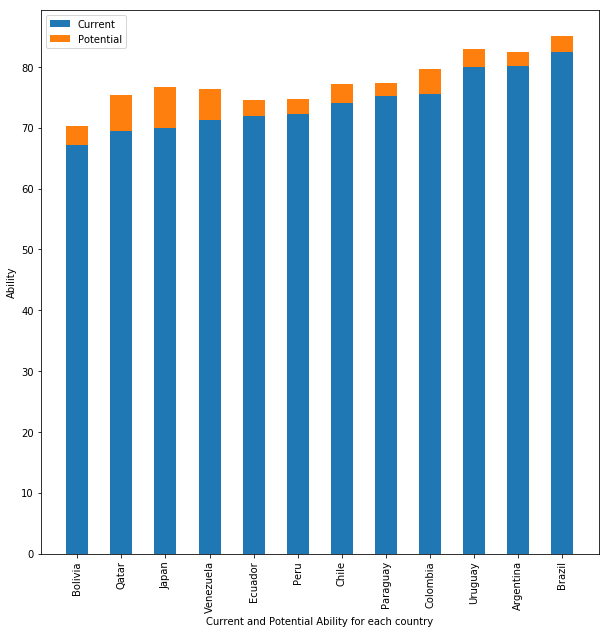

In [40]:
current = grp['Overall']
potential = grp['Points to potential']
ind = np.arange(12)
width = 0.5
plt.figure(figsize=(10,10))
p1 = plt.bar(ind,current,width)
p2 = plt.bar(ind,potential,width,bottom=current)
plt.ylabel('Ability')
plt.xlabel('Current and Potential Ability for each country')
plt.xticks(ind,(grp.index),rotation=90)
plt.legend((p1[0],p2[0]),('Current','Potential'))
plt.show()

We can see that __Brazil__ has the highest current ability while __Japan__ is most under potential.

## 6. Variables to build Poisson Model

- Soccer Power Index
- Average Age
- Average Height
- Past Participation
- Average goals scored per game
- Average goals conceded per game
- Potential
- Current Ability

In [41]:
grp.reset_index(inplace=True)
spi=pd.merge(left=df,right=grp,how='left',left_on=['Name'],right_on=['Nationality']).dropna().drop(['Nationality'],axis=1)
spi=pd.merge(left=spi,right=history,how='left',left_on=['Name'],right_on=['Team']).drop(['Team'],axis=1)
fixtures=pd.merge(left=fixtures,right=spi,how='left',left_on=['Team'],right_on=['Name']).drop(['Name'],axis=1).fillna(0)
fixtures["avg score"] = round(fixtures['GF'] / fixtures['GP'],2)
fixtures["avg conceded"] = round(fixtures['GA'] / fixtures['GP'],2)
fixtures.iloc[0:,[5,6,7,9,-2,-1]].fillna(0,inplace=True)
sc=StandardScaler()
fixtures[['Part.','Overall','Potential']]=sc.fit_transform(fixtures[['Part.','Overall','Potential']])
fixtures.head()

,Team,Group,First_match_Against,Second_match_Against,Third_match_Against,SPI,Age,Height,Overall,Potential,...,GP,W,D,L,GF,GA,Dif,Pts/GP,avg score,avg conceded
0,Brazil,A,Bolivia,Venezuela,Peru,2.39,27.00,180.09,1.829519,1.835141,...,178.0,99.0,35.0,44.0,405.0,200.0,205.0,1.87,2.28,1.12
1,Bolivia,A,Brazil,Peru,Venezuela,0.17,26.48,176.83,-1.542981,-1.877166,...,112.0,20.0,26.0,66.0,104.0,279.0,-175.0,0.77,0.93,2.49
2,Venezuela,A,Peru,Brazil,Bolivia,0.73,24.61,179.22,-0.626206,-0.336821,...,62.0,7.0,13.0,42.0,47.0,171.0,-124.0,0.55,0.76,2.76
3,Peru,A,Venezuela,Bolivia,Brazil,1.25,26.57,177.35,-0.415150,-0.771213,...,148.0,54.0,35.0,59.0,213.0,232.0,-19.0,1.33,1.44,1.57
4,Argentina,B,Colombia,Paraguay,Qatar,1.59,26.70,180.30,1.332658,1.193539,...,189.0,120.0,38.0,31.0,455.0,173.0,282.0,2.11,2.41,0.92


## 7. Predicting Copa America 2019

### Combination of Poisson Distribution and Random Forest to Predict Goals Scored

 - __Base Goals__ = Average goals scored by X against Y = min(Ave_goals_scored_per_game (X), Ave_goals_conceded_per_game(Y))
 - __Difference in Teams__ =  0.35*(diff. in Soccer_Power_index) + 0.20*(diff. in Potential) + 0.20*(diff. in total_participation) + 0.05 (diff. in Average_height) - 0.05 * (diff. in Average_age) + 0.15*(diff. in current overall ability)
 
The current ability plays an important role as to how much the teams differ in quality.

The potential of the players and the experience (total_participation) would also play a important role in a match, especially in a semi-final/final.

Least weights were given to the height (Headers advantage) and age (might be correlated with their stamina) as they might play a small part in some parts of the match. Age difference was "subtracted" because the younger the player is, there is a higher change of having more stamina, hence lower age is "better".

 - __Mean Goals Scored__ = max(0, Base Goals + Difference in Teams)

Now to calculate probability of goals scored, we will combine Poisson Distribution and Random Forest Classifier as,
Probability(i Goals Scored) = 0.7*(poisson.pmf(i, Mean Goals Scored)) + 0.3*(Random Forest Probability of i Goals)

Eg. P(0 goals) = 0.7*(poisson.pmf(0, Mean Goals Scored)) + 0.3*(Random Forest Probability of 0 Goals)

We then calculate the probability for 0,1,2,3,4,5,6 Goals using above equation.

Predicted no. of goals will be the one with highest probability.

#### Training the selected classifier(s) for Group Matches

In [42]:
features = result.loc[0:,['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff']]
labels = result.loc[:,['results']]
rf_class = RandomForestClassifier(n_estimators=250,max_depth= 8, max_leaf_nodes=100, min_samples_leaf= 5, min_samples_split= 5, n_jobs=-1)
rf_class.fit(features,labels)

from itertools import combinations
opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']
fixtures['Points'] = 0
fixtures['Total_Prob'] = 0
fixtures.set_index('Team',inplace=True)
current_ranking.set_index('country_full',inplace=True)

#### Group Stage

In [43]:
for group in list(fixtures['Group'].unique()):
    print('___Group {}___'.format(group))
    for home, away in combinations(fixtures.query('Group == "{}"'.format(group)).index, 2):
        print('{} vs. {}: '.format(home, away), end='')
        match = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]]), columns=['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff'])
        match['host'] = 1 if home=='Brazil' or away=='Brazil' else 0
        match['impt'] = 1
        match['home_pts_diff'] = current_ranking.loc[home,'pts_diff']
        match['away_pts_diff'] = current_ranking.loc[away,'pts_diff']
        match['rank_diff'] = current_ranking.loc[home,'rank'] - current_ranking.loc[away,'rank']
        match['weighted_diff'] = current_ranking.loc[home,'mean_weighted'] - current_ranking.loc[away,'mean_weighted']
        
        home_win_prob = rf_class.predict_proba(match)[:,2][0]
        away_win_prob = rf_class.predict_proba(match)[:,0][0]
        draw_prob = rf_class.predict_proba(match)[:,1][0]
        
        points = 0
        if max(home_win_prob,away_win_prob,draw_prob) == away_win_prob:
            print("{} wins with a probability of {:.2f}% ".format(away, away_win_prob))
            fixtures.loc[away, 'Points'] += 3
            fixtures.loc[home, 'Total_Prob'] += home_win_prob
            fixtures.loc[away, 'Total_Prob'] += away_win_prob
        elif max(home_win_prob,away_win_prob,draw_prob) == draw_prob:
            points = 1
            print("Draw with probability of {:.2f}%".format(draw_prob))
            fixtures.loc[home, 'Points'] += 1
            fixtures.loc[away, 'Points'] += 1
            fixtures.loc[home, 'Total_Prob'] += draw_prob
            fixtures.loc[away, 'Total_Prob'] += draw_prob
        elif max(home_win_prob,away_win_prob,draw_prob) == home_win_prob:
            points = 3
            fixtures.loc[home, 'Points'] += 3
            fixtures.loc[home, 'Total_Prob'] += home_win_prob
            fixtures.loc[away, 'Total_Prob'] += away_win_prob
            print("{} wins with a probability of {:.2f}%".format(home, home_win_prob))
    print()

___Group A___
Brazil vs. Bolivia: Brazil wins with a probability of 0.83%
Brazil vs. Venezuela: Brazil wins with a probability of 0.70%
Brazil vs. Peru: Brazil wins with a probability of 0.71%
Bolivia vs. Venezuela: Venezuela wins with a probability of 0.40% 
Bolivia vs. Peru: Peru wins with a probability of 0.60% 
Venezuela vs. Peru: Peru wins with a probability of 0.57% 

___Group B___
Argentina vs. Colombia: Argentina wins with a probability of 0.52%
Argentina vs. Paraguay: Argentina wins with a probability of 0.61%
Argentina vs. Qatar: Argentina wins with a probability of 0.70%
Colombia vs. Paraguay: Colombia wins with a probability of 0.67%
Colombia vs. Qatar: Colombia wins with a probability of 0.73%
Paraguay vs. Qatar: Paraguay wins with a probability of 0.64%

___Group C___
Uruguay vs. Ecuador: Uruguay wins with a probability of 0.68%
Uruguay vs. Japan: Uruguay wins with a probability of 0.58%
Uruguay vs. Chile: Uruguay wins with a probability of 0.36%
Ecuador vs. Japan: Japan 

Some probabilities are not more than 50% because the maximum of (Win Probability, Draw Probability and Loss Probability) is taken to make the decision, and hence the maximum probability selected might not be more than 50%.

#### Function to simulate a knockout match

In [44]:
def knockout(home,away):
    print("{} vs. {}: ".format(home, away), end='')
    match = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]]), columns=['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff'])
    match['host'] = 1 if home=='Brazil' or away=='Brazil' else 0
    match['impt'] = 1
    match['home_pts_diff'] = current_ranking.loc[home,'pts_diff']
    match['away_pts_diff'] = current_ranking.loc[away,'pts_diff']
    match['rank_diff'] = current_ranking.loc[home,'rank'] - current_ranking.loc[away,'rank']
    match['weighted_diff'] = current_ranking.loc[home,'mean_weighted'] - current_ranking.loc[away,'mean_weighted']
    base_home_goals = max(fixtures.loc[home,'avg score'],fixtures.loc[away,'avg conceded'])
    base_away_goals = max(fixtures.loc[home,'avg conceded'],fixtures.loc[away,'avg score'])
    home_diff_in_countries = (0.35*(fixtures.loc[home,'SPI']-fixtures.loc[away,'SPI']) +
                              0.20*(fixtures.loc[home,'Potential']-fixtures.loc[away,'Potential'])+
                              0.20*(fixtures.loc[home,'Part.']-fixtures.loc[away,'Part.'])-
                              0.05*(fixtures.loc[home,'Age']-fixtures.loc[away,'Age'])+
                              0.05*(fixtures.loc[home,'Height']-fixtures.loc[away,'Height'])+
                              0.15*(fixtures.loc[home,'Overall']-fixtures.loc[away,'Overall']))
    
    away_diff_in_countries = (0.35*(fixtures.loc[away,'SPI']-fixtures.loc[home,'SPI']) +
                              0.20*(fixtures.loc[away,'Potential']-fixtures.loc[home,'Potential'])+
                              0.20*(fixtures.loc[away,'Part.']-fixtures.loc[home,'Part.'])-
                              0.05*(fixtures.loc[away,'Age']-fixtures.loc[home,'Age'])+
                              0.05*(fixtures.loc[away,'Height']-fixtures.loc[home,'Height'])+
                              0.15*(fixtures.loc[away,'Overall']-fixtures.loc[home,'Overall']))
    
    mean_home_goals = max(0,base_home_goals + home_diff_in_countries)
    mean_away_goals = max(0,base_away_goals + away_diff_in_countries)
    home_prob_goals = list()
    away_prob_goals = list()
    home_prob_goals_rfmodel = list(rf_home.predict_proba(match)[0])
    away_prob_goals_rfmodel = list(rf_away.predict_proba(match)[0])
    for i in range(7):
        home_prob_goals.append(0.7*poisson.pmf(i,mean_home_goals) + 0.3*home_prob_goals_rfmodel[i])
        away_prob_goals.append(0.7*poisson.pmf(i,mean_away_goals) + 0.3*away_prob_goals_rfmodel[i])
    
    home_goals = np.argmax(home_prob_goals)
    away_goals = np.argmax(away_prob_goals)
    
    if home_goals>away_goals:
        print("{} wins {} with score of {}:{}".format(home,away,str(home_goals),str(away_goals)),end='')
        winners.append(home)
        losers.append(away)
    elif home_goals<away_goals:
        print("{} wins {} with score of {}:{}".format(away,home,str(away_goals),str(home_goals)),end='')
        winners.append(away)
        losers.append(home)
    else:
        team = [home,away]
        win = random.choice(team)
        team.remove(win)
        loser = team[0]
        print("{} draws with {} with a score of {}:{} after Extra-Time and {} wins the Penalty Shootout".format(home,away,str(home_goals),str(away_goals),win),end='')
        winners.append(win)
        losers.append(loser)
    print()

#### Training the selected classifier(s) for Knockout Matches

In [45]:
features = result.loc[0:,['host','impt','home_pts_diff','away_pts_diff','rank_diff','weighted_diff']]
labels_home = result.loc[:,['home_score']]
labels_away = result.loc[:,['away_score']]

rf_home = RandomForestClassifier(n_estimators=100,max_depth= 8, max_leaf_nodes=110, min_samples_leaf= 2, min_samples_split= 2, n_jobs=-1)
rf_home.fit(features,labels_home)
rf_away = RandomForestClassifier(n_estimators=100,max_depth= 7, max_leaf_nodes=90, min_samples_leaf= 4, min_samples_split= 2, n_jobs=-1)
rf_away.fit(features,labels_away)

print()

#### Creating fixtures for Knockout Stages

In [46]:
pairing = [0,7,3,4,1,5,2,6]
fixtures = fixtures.sort_values(['Points','Group'],ascending=[False,True]).reset_index()
Finals = fixtures.groupby('Group').nth([0,1]).reset_index().set_index('Team')
#Finals.sort_values(['Points','Group'],ascending=[False,True],inplace=True)
thirdPlaced=fixtures.groupby('Group').nth([2]).sort_values(['Points','Total_Prob'],ascending=[False,False]).reset_index().set_index('Team')
Finals=Finals.append(thirdPlaced.iloc[:2,:])
Finals.sort_values(['Points','Group'],ascending=[False,True],inplace=True)
Finals.reset_index(inplace=True)
Finals = Finals.loc[pairing].set_index('Team')
fixtures.set_index('Team',inplace=True)
Finals.head()

,Group,Age,D,Dif,First_match_Against,GA,GF,GP,Height,L,...,Pts,Pts/GP,SPI,Second_match_Against,Third_match_Against,Total_Prob,W,Winners,avg conceded,avg score
Team,,,,,,,,,,,,,,,,,,,,,
Brazil,A,27.00,35.0,205.0,Bolivia,200.0,405.0,178.0,180.09,44.0,...,332.0,1.87,2.39,Venezuela,Peru,2.240562,99.0,8.0,1.12,2.28
Paraguay,B,27.52,39.0,-40.0,Qatar,293.0,253.0,168.0,178.48,67.0,...,225.0,1.34,0.90,Argentina,Colombia,0.885932,62.0,2.0,1.74,1.51
Peru,A,26.57,35.0,-19.0,Venezuela,232.0,213.0,148.0,177.35,59.0,...,197.0,1.33,1.25,Bolivia,Brazil,1.248531,54.0,2.0,1.57,1.44
Colombia,B,25.52,24.0,-53.0,Argentina,184.0,131.0,113.0,182.22,47.0,...,150.0,1.33,1.60,Qatar,Paraguay,1.636587,42.0,1.0,1.63,1.16
Argentina,B,26.70,38.0,282.0,Colombia,173.0,455.0,189.0,180.30,31.0,...,398.0,2.11,1.59,Paraguay,Qatar,1.837214,120.0,14.0,0.92,2.41


#### Quarterfinals and Semifinals

In [47]:
finals = ['Quarter-Finals','Semi-Finals']

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(Finals) / 2)
    winners = list()
    losers = list()
    for i in range(iterations):
        home = Finals.index[i*2]
        away = Finals.index[i*2+1]        
        knockout(home,away)
    Finals = Finals.loc[winners]    
    if len(winners)>2:
        print('\nSemi-Finalists: ' + winners[0] + ',' + winners[1] + ',' + winners[2] + ',' + winners[3] + '\n')
    else:
        print('\nFinalists: ' + winners[0] + ',' + winners[1] + '\n')

finalists = winners

___Starting of the Quarter-Finals___
Brazil vs. Paraguay: Brazil wins Paraguay with score of 2:0
Peru vs. Colombia: Colombia wins Peru with score of 1:0
Argentina vs. Chile: Argentina wins Chile with score of 2:0
Uruguay vs. Venezuela: Uruguay wins Venezuela with score of 3:0

Semi-Finalists: Brazil,Colombia,Argentina,Uruguay

___Starting of the Semi-Finals___
Brazil vs. Colombia: Brazil wins Colombia with score of 2:0
Argentina vs. Uruguay: Argentina draws with Uruguay with a score of 1:1 after Extra-Time and Uruguay wins the Penalty Shootout

Finalists: Brazil,Uruguay



#### Third Place Playoff and Final

In [48]:
print("___Third Place Playoff___")
home = losers[0]
away = losers[1]
winners = list()
losers = list()
knockout(home,away)
third = winners[0]
fourth = losers[0]

print("\n___Copa America Final___")
home = finalists[0]
away = finalists[1]
knockout(home,away)
champion = winners[1]
runners_up = losers[1]

print("\n{} wins the Copa America 2019.\n".format(champion))
print("{} are Runners-up.\n".format(runners_up))
print("{} secures Third place.\n".format(third))
print("{} secures Fourth place after losing from {} in the Playoff\n".format(fourth,third))

___Third Place Playoff___
Colombia vs. Argentina: Argentina wins Colombia with score of 2:0

___Copa America Final___
Brazil vs. Uruguay: Brazil wins Uruguay with score of 2:1

Brazil wins the Copa America 2019.

Uruguay are Runners-up.

Argentina secures Third place.

Colombia secures Fourth place after losing from Argentina in the Playoff

